In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import morphology
import pandas as pd
import seaborn as sns
from helpers import sns_styleset
%matplotlib inline

In [2]:
sns_styleset()

In [3]:
skeleton_data=loadmat('./data/Skeletons_HC_BC_cones.mat')
skeleton_ids=skeleton_data['kn_allSkeletons_e2006_IDs'].flatten()
skeletons=skeleton_data['kn_allSkeletons_e2006'].flatten()
M=np.loadtxt('./data/coordinate_rotation')
BC_ids=np.loadtxt('./data/BC_IDs_new').astype(int)

In [4]:
# load cone center points, transition to nm and align the light axis

cone_centers=np.loadtxt('./data/cone_means_rotated.txt')
cone_centers[:,1:]*=[49.5,49.5,50]
cone_boundaries=np.loadtxt('./data/cone_boundaries_rotated.txt')
cone_boundaries[:,1:]*=49.5

In [5]:
cell_ids=[]
for i in range(BC_ids.shape[0]):
    if BC_ids[i,4] in range(58,72):
        cell_ids.append([BC_ids[i,0],BC_ids[i,4]])
for i in skeleton_ids:
    if (i >1900)&(i<2000):
        cell_ids.append([i,90])
    if (i >2000)&(i<3000):
        cell_ids.append([i,80])
    elif (i>3000):
        cell_ids.append([i,84])
cell_ids=np.array(cell_ids).astype(int)
cone_ids=cell_ids[(cell_ids[:,1]>=80)&(cell_ids[:,1]<84)]

In [6]:
nodes_complete=[]
edges_complete=[]
for i in range(len(skeleton_ids)):
    nodes=skeletons[i].item()[list(skeletons[i].dtype.names).index('nodes')][:,:3]
    edges=skeletons[i].item()[list(skeletons[i].dtype.names).index('edges')]
    nodes=nodes[np.unique(edges)-1,:]
    edge_numbers=np.unique(edges)
    edge_mapping=np.vstack((edge_numbers,np.arange(1,edge_numbers.shape[0]+1))).T
    edges_new=np.zeros(edges.shape)
    for k in range(edges.shape[0]):
        edges_new[k,0]=edge_mapping[edge_mapping[:,0]==edges[k,0],1]
        edges_new[k,1]=edge_mapping[edge_mapping[:,0]==edges[k,1],1]
    nodes_complete.append(nodes)
    edges_complete.append(edges_new)

In [7]:
contact_data=loadmat('./data/HC_BC_cones_contacts.mat')['kn_allContactData_Interfaces']

contact_data_reduced=contact_data[(contact_data[:,4]>64) & (contact_data[:,4]<192) &
                                  (contact_data[:,5]>64) & (contact_data[:,5]<192) &
                                  (contact_data[:,6]>64) & (contact_data[:,6]<192),:]

contact_data_reduced2=np.hstack((contact_data_reduced[:,:2],
                                (contact_data_reduced[:,4]+contact_data_reduced[:,11]+64).reshape(-1,1),\
                                (contact_data_reduced[:,5]+contact_data_reduced[:,12]+64).reshape(-1,1),\
                                (contact_data_reduced[:,6]+contact_data_reduced[:,13]+64).reshape(-1,1),\
                                contact_data_reduced[:,14].reshape(-1,1)))
contact_data_reduced2[:,2:5]*=[16.5,16.5,25]  # to nm
contact_data_reduced2[:,2:5]=np.dot(M,contact_data_reduced2[:,2:5].T).T  # rotation to align the light axis

In [8]:
# select contacts between HCs and cones with area >0
HC_cone_contacts=contact_data_reduced2[(contact_data_reduced2[:,0]>1900)&(contact_data_reduced2[:,0]<2000)&\
                                       (contact_data_reduced2[:,1]>2000)&(contact_data_reduced2[:,1]<3000)]
HC_cone_contacts=HC_cone_contacts[HC_cone_contacts[:,5]>0]
HC_cone_contacts=pd.DataFrame(HC_cone_contacts,columns=['HC','cone','x_pos','y_pos','z_pos','area'])

In [9]:
# number of cones contacted by HCs as stated in the results section
cones_contacted=[]
for HC in np.unique(HC_cone_contacts['HC']):
    if HC>1901:
        cones_contacted.append(len(np.unique(HC_cone_contacts.loc[HC_cone_contacts['HC']==HC,'cone'])))
np.array(cones_contacted)
print('Number of cones contacted per HC')
print('Mean {:.2f}, SD {:.2f}'.format(np.mean(cones_contacted),np.std(cones_contacted)/np.sqrt(len(cones_contacted)-1)))
print('Min {}, max {}'.format(np.min(cones_contacted),np.max(cones_contacted)))

Number of cones contacted per HC
Mean 60.80, SD 4.54
Min 51, max 77


In [10]:
#set soma positions direclty
HC_soma=np.array([[1902.,2828.,3667.,1667.],\
                  [1903.,2890.,1776.,1952.],\
                  [1904.,2854.,4568.,1838.],\
                  [1905.,2991.,4261.,970.],\
                  [1906.,2910.,1999.,1120.]])
HC_soma[:,1:]*=[16.5,16.5,25]
HC_soma[:,1:]=np.dot(M,HC_soma[:,1:].T).T
HC_soma=pd.DataFrame(HC_soma,columns=['HC','x','y','z'])

In [11]:
HC_contacts_agg=[]
for HC in np.unique(HC_soma['HC']):
    for cone in np.unique(HC_cone_contacts.loc[HC_cone_contacts['HC']==HC,'cone']):
        area=np.sum(HC_cone_contacts.loc[(HC_cone_contacts['HC']==HC)&(HC_cone_contacts['cone']==cone),'area'])
        distance=np.linalg.norm(HC_soma.loc[HC_soma['HC']==HC,['y','z']]-cone_centers[cone_centers[:,0]==cone,2:])/1e3
        HC_contacts_agg.append([HC,cone,area,distance])
HC_contacts_agg=pd.DataFrame(HC_contacts_agg,columns=['HC','cone','area','distance'])

In [12]:
tip_list=[]
id_list=[]
for HC in np.unique(HC_soma['HC']):
    nodes=[]
    edges=[]
    for cell in np.where(skeleton_ids==HC)[0]:
        nodes.append(nodes_complete[cell])
        edges.append(edges_complete[cell])  
    num_skel=len(nodes)
    tips=np.empty((0,3))
    for skel in range(num_skel):
        a,c=np.unique(edges[skel],return_counts=True)
        tips=np.concatenate((tips,nodes[skel][a[c==1].astype(int)-1]),axis=0)
    id_list.append(HC)
    tip_list.append(tips)

In [13]:
cone_projections=[]
for i in range(cone_ids.shape[0]):
    data=np.loadtxt('./data/cone_projections/cell'+str(cone_ids[i,0]).zfill(4)+'_rot_x_complete.gz')#still false rotation
    cone_projections.append(data)

In [14]:
#define structure with radius 0.75µm (=15px a 50nm)
struct=np.zeros((31,31))
for i in range(31):
    for j in range(31):
        if (i-15)**2+(j-15)**2<=225:
            struct[i,j]=1
#define structure with radius 0.25µm (=5px a 50nm)
struct2=np.zeros((11,11))
for i in range(11):
    for j in range(11):
        if (i-5)**2+(j-5)**2<=25:
            struct2[i,j]=1

In [15]:
# cone_projections_reduced=[]
cone_projections_extended=[]
for i in range(cone_ids.shape[0]):
    data=(cone_projections[i]).astype(int)#still have to scale it correctly
    data_min=np.min(data,axis=0)-np.array([5,5])#added a margin of 5 for extended
    data=data-data_min
    data_max=np.max(data,axis=0)+np.array([5,5])
    data_im=np.zeros(data_max+1)
    data_im[tuple(data.astype(int).T)]=1
    data_im=morphology.grey_opening(data_im,footprint=struct)
#     data2=np.array(np.where(data_im==1)).T+data_min
#     cone_projections_reduced.append(data2)#*np.array([3,2]))
    data_im=morphology.grey_dilation(data_im,footprint=struct2)
    data2=np.array(np.where(data_im==1)).T+data_min
    cone_projections_extended.append(data2)#*np.array([3,2]))

In [16]:
#draft of tip data agglomeration
HC_tips_agg=[]
bottom_tolerance=5#20 #20*50nm #60*16.5nm=um
for i in range(5):
    HC=id_list[i]
#     tip_positions=(tip_list[i]/np.array([49.5,49.5,50])).astype(int)
    tip_positions=(tip_list[i]/[16.5,16.5,25])
    tip_positions=(np.dot(M,tip_positions.T).T/np.array([3,3,2])).astype(int)
    #get rotation/scaling right, probably downscaled from original, rotated or not?
    for cone in np.unique(HC_cone_contacts.loc[HC_cone_contacts['HC']==HC,'cone']):
        #get (reduced?) cone area & lowest point
        #count HC tips in the volume inside the cone
        j=np.where(cone_ids[:,0]==cone)[0].item()
        cone_bottom=cone_boundaries[cone_boundaries[:,0]==cone,2]/16.5/3+bottom_tolerance
        cone_area=cone_projections_extended[j].astype(int)
        in_area=np.where(np.in1d(np.ascontiguousarray(tip_positions[:,1:]).view(dtype='int64,int64').reshape(tip_positions.shape[0]),\
                  np.ascontiguousarray(cone_area).view(dtype='int64,int64').reshape(cone_area.shape[0])))[0]
        above_bottom=np.where(tip_positions[:,0]<cone_bottom)[0]
        count=len(np.intersect1d(in_area,above_bottom))
        distance=np.linalg.norm(HC_soma.loc[HC_soma['HC']==HC,['y','z']]-cone_centers[cone_centers[:,0]==cone,2:])/1e3
        HC_tips_agg.append([HC,cone,count,distance])
HC_tips_agg=pd.DataFrame(HC_tips_agg,columns=['HC','cone','tips','distance'])

In [17]:
HC_all_agg=pd.merge(HC_contacts_agg,HC_tips_agg, on=['HC', 'cone','distance'])

In [18]:
HC_all_agg=HC_all_agg[HC_all_agg['tips']>0]
HC_all_agg['area'] = HC_all_agg['area']/1e6

## GAM, Figures 1F and 1G

In [19]:
%load_ext rpy2.ipython

In [20]:
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter

pandas2ri.activate()

In [21]:
r_data = ro.DataFrame({'HC': ro.vectors.IntVector(HC_all_agg['HC'].values.astype(int)),
                       'distance': ro.vectors.FloatVector(HC_all_agg['distance'].values),
                       'area': ro.vectors.FloatVector(HC_all_agg['area'].values),
                       'tips': ro.vectors.IntVector(HC_all_agg['tips'].values.astype(int))})

In [22]:
r_mgcv  = importr('mgcv')
r_stats = importr('stats')
r_base = importr('base')

/usr/local/lib/python3.8/dist-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [23]:
model = r_mgcv.gam(ro.Formula('tips ~ s(distance) +s(HC, bs="re")'),data=r_data,family='poisson')
r_pred=r_stats.predict(model,newdata=r_data,type = "response",**{'se.fit':True})
prediction=np.array(r_pred)

In [24]:
model2 = r_mgcv.gam(ro.Formula('area ~ s(distance) +s(HC, bs="re")'),data=r_data,family='Gamma')
r_pred2=r_stats.predict(model2,newdata=r_data,type = "response",**{'se.fit':True})
prediction2=np.array(r_pred2)

In [25]:
print(r_base.summary(model))


Family: poisson 
Link function: log 

Formula:
tips ~ s(distance) + s(HC, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.03645    0.03009   67.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df Chi.sq p-value    
s(distance) 6.182e+00  7.346  457.9  <2e-16 ***
s(HC)       5.594e-07  1.000    0.0   0.642    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.336   Deviance explained = 37.5%
UBRE = 1.8814  Scale est. = 1         n = 289



In [26]:
print(r_base.summary(model2))


Family: Gamma 
Link function: inverse 

Formula:
area ~ s(distance) + s(HC, bs = "re")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.28461    0.02225   12.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df     F  p-value    
s(distance) 2.605e+00  3.294 10.91 6.74e-07 ***
s(HC)       3.312e-07  1.000  0.00   0.0106 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.158   Deviance explained = 14.6%
GCV = 1.0196  Scale est. = 1.1847    n = 289



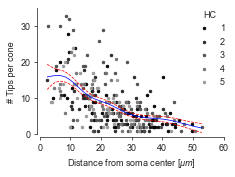

In [27]:
plt.figure(figsize=(8.5/2.54,6.5/2.54),tight_layout=True)
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1902,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1902,'tips'],s=7,label='1',c='0')
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1903,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1903,'tips'],s=7,label='2',c='0.15')
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1904,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1904,'tips'],s=7,label='3',c='0.30')
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1905,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1905,'tips'],s=7,label='4',c='0.45')
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1906,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1906,'tips'],s=7,label='5',c='0.60')
plt.plot(np.sort(HC_all_agg['distance']),prediction[0,np.argsort(HC_all_agg['distance'])],'b')
plt.plot(np.sort(HC_all_agg['distance']),(prediction[0,:]+2*prediction[1,:])[np.argsort(HC_all_agg['distance'])],'r--')
plt.plot(np.sort(HC_all_agg['distance']),(prediction[0,:]-2*prediction[1,:])[np.argsort(HC_all_agg['distance'])],'r--')
plt.xlabel('Distance from soma center [$\it{\mu m}$]')
plt.ylabel('# Tips per cone')
plt.xlim(0,60)
plt.ylim(0,35)
sns.despine(offset=3)
plt.legend(title='HC',title_fontsize='9',fontsize='9',frameon=False,loc=1,bbox_to_anchor=(1.05,1.05))
# plt.savefig('./figures/Fig1F_HC_tips_vs_distance.svg',dpi=300)
plt.show()

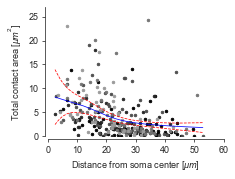

In [28]:
plt.figure(figsize=(8.5/2.54,6.5/2.54),tight_layout=True)
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1902,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1902,'area'],s=7,label='1',c='0')
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1903,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1903,'area'],s=7,label='2',c='0.15')
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1904,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1904,'area'],s=7,label='3',c='0.3')
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1905,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1905,'area'],s=7,label='4',c='0.45')
plt.scatter(HC_all_agg.loc[HC_all_agg['HC']==1906,'distance'],HC_all_agg.loc[HC_all_agg['HC']==1906,'area'],s=7,label='5',c='0.6')
plt.plot(np.sort(HC_all_agg['distance']),prediction2[0,np.argsort(HC_all_agg['distance'])],'b')
plt.plot(np.sort(HC_all_agg['distance']),(prediction2[0,:]+2*prediction2[1,:])[np.argsort(HC_all_agg['distance'])],'r--')
plt.plot(np.sort(HC_all_agg['distance']),(prediction2[0,:]-2*prediction2[1,:])[np.argsort(HC_all_agg['distance'])],'r--')
plt.xlabel('Distance from soma center [$\it{\mu m}$]')
plt.ylabel('Total contact area [$\it{\mu m^2}$]')
plt.xlim(0,60)
plt.ylim(0,27)
sns.despine(offset=3)
# plt.savefig('./figures/Fig1G_HC_contact_area_vs_distance.svg',dpi=300)
plt.show()

## Figure 2E, bulb density vs. distance

In [29]:
bulb_positions=pd.read_csv('./data/HC_bulb_contacts.csv',delimiter=';')[['HC','x','y','z']]
bulb_positions.iloc[:,1:]=bulb_positions.iloc[:,1:]*[16.5,16.5,25]
bulb_positions.iloc[:,1:]=np.dot(M,bulb_positions.iloc[:,1:].T).T

In [30]:
for i in range(len(bulb_positions)):
    bulb_positions.loc[i,'dist']=np.linalg.norm(bulb_positions.loc[i,['y','z']]-HC_soma.loc[HC_soma['HC']==bulb_positions.loc[i,'HC'],['y','z']])

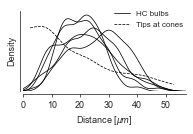

In [31]:
plt.figure(figsize=(7/2.54,5/2.54),tight_layout=True)
HC=HC_soma.loc[0,'HC']
ax = sns.kdeplot(bulb_positions.loc[(bulb_positions['HC']==HC)&(bulb_positions['dist']<50000),'dist']/1e3,bw_method=0.3,label='HC bulbs',color='0')#str(0.15*i))
for i in range(1,5):
    HC=HC_soma.loc[i,'HC']
    sns.kdeplot(bulb_positions.loc[(bulb_positions['HC']==HC)&(bulb_positions['dist']<50000),'dist']/1e3,bw_method=0.3,color='0',label='')#str(0.15*i))
plt.plot(np.sort(HC_all_agg['distance']),prediction[0,np.argsort(HC_all_agg['distance'])]/\
         np.trapz(prediction[0,np.argsort(HC_all_agg['distance'])],np.sort(HC_all_agg['distance'])),color='0',ls='--',label='Tips at cones')
plt.xlabel('Distance [$\it{\mu m}$]')
plt.ylabel('Density')
plt.xlim(0,57)
plt.yticks([])
plt.xticks([0,10,20,30,40,50])
plt.legend(loc=1,frameon=False,bbox_to_anchor=(1.03,1.1))
sns.despine(offset=3)
# plt.savefig('./figures/Fig2E_HC_bulbs_vs_distance.svg',dpi=300)#,bbox_inches='tight',dpi=300)
plt.show()